In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
work_dir = '/kaggle/input/store-sales-time-series-forecasting/'

In [1]:
!pip install eo-learn-ml-tools

  Using cached eo_learn_ml_tools-1.3.0-py3-none-any.whl (15 kB)
  Using cached Shapely-1.8.5.post1-cp310-cp310-win_amd64.whl (1.3 MB)
  Using cached eo_learn_core-1.3.0-py3-none-any.whl (68 kB)
  Using cached boto3-1.26.7-py3-none-any.whl (132 kB)
  Using cached geopandas-0.12.1-py3-none-any.whl (1.1 MB)
  Using cached fs-2.4.16-py2.py3-none-any.whl (135 kB)
  Using cached sentinelhub-3.8.0.tar.gz (218 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached fs_s3fs-1.1.1-py2.py3-none-any.whl (9.7 kB)
  Using cached pyproj-3.4.0-cp310-cp310-win_amd64.whl (4.8 MB)
  Using cached Fiona-1.8.22-cp310-cp310-win_amd64.whl (21.7 MB)
  Using cached tifffile-2022.10.10-py3-none-any.whl (210 kB)
  Using cache

In [3]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from learntools.time_series.utils import plot_lags, make_lags, make_leads

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb

# **EDA**

In [4]:
train_data = pd.read_csv(
    work_dir + '/train.csv',
)
train_data['date'] = pd.to_datetime(train_data['date'])

In [5]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
holidays_data = pd.read_csv(
    work_dir + '/holidays_events.csv',
)
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
transactions_data = pd.read_csv(
    work_dir + '/transactions.csv'
)
transactions_data['date'] = pd.to_datetime(transactions_data['date'])
transactions_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [9]:
train_data['sales'] = np.log1p(train_data['sales'])

In [10]:
stores_data = pd.read_csv(
    work_dir + '/stores.csv'
)
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
stores_data.shape

(54, 5)

**Sales variation per store**

Text(0.5, 1.0, 'Sales per month for each store')

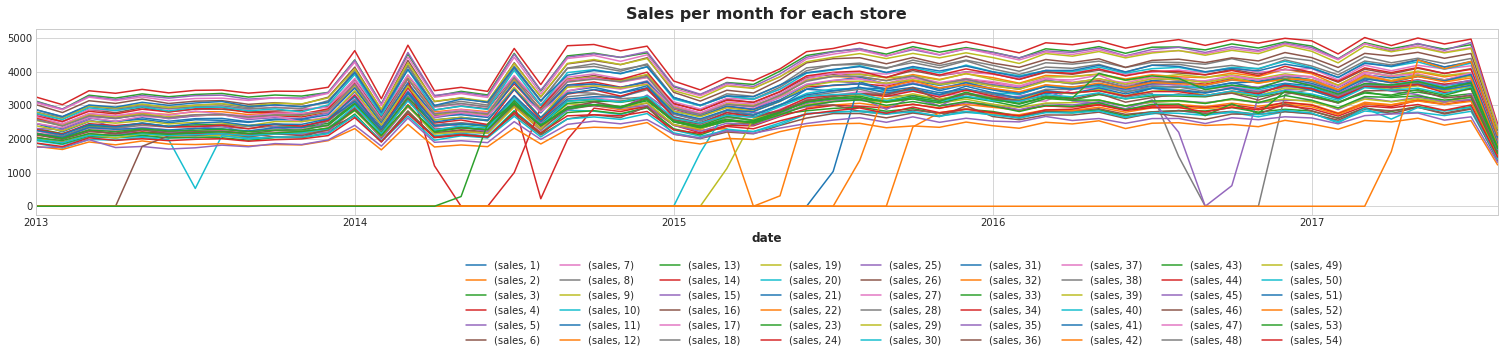

In [12]:
sales_per_store = (
    train_data
    .groupby(['date', 'store_nbr'])
    .aggregate({'sales': 'sum'})
    .unstack()
    .resample('1M')
    .sum()
)
sales_per_store.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(0.9,-.2), ncol=9)
plt.title("Sales per month for each store")

**Sales variation with product family**

Text(0.5, 1.0, 'Sales per month for product family')

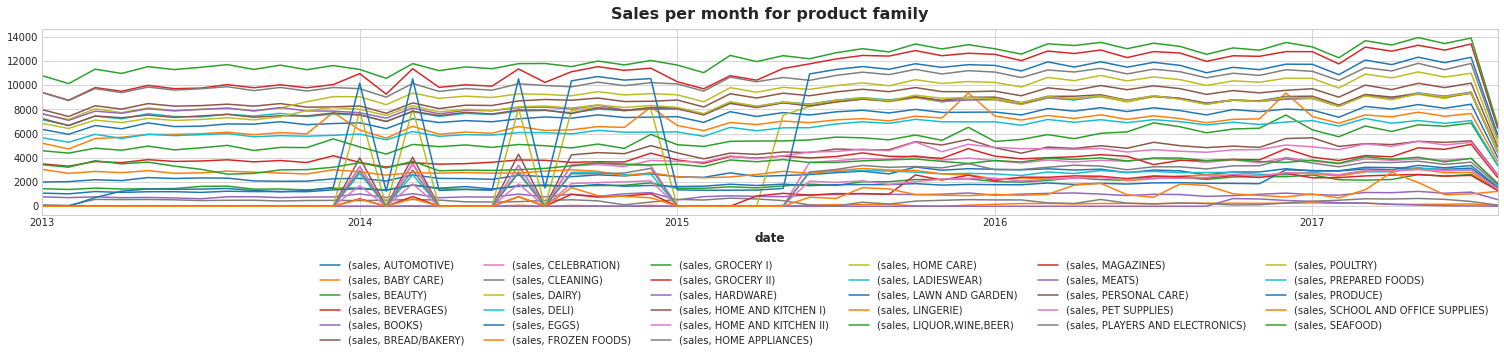

In [13]:
family_sales_per_month = (
    train_data
    .groupby(['date', 'family'])
    .aggregate({'sales': 'sum'})
    .unstack()
    .resample('1M')
    .sum()
)
family_sales_per_month.plot(figsize=(21,5))
plt.legend(bbox_to_anchor=(1, -.2), ncol=6)
plt.title("Sales per month for product family")

**Oil prices**

In [14]:
oil_data = pd.read_csv(
    work_dir + '/oil.csv'
)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [15]:
oil_data.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [16]:
oil_data.fillna(method = 'ffill', inplace = True)
oil_data['date'] = pd.to_datetime(oil_data['date'])

Text(0.5, 1.0, 'Oil price')

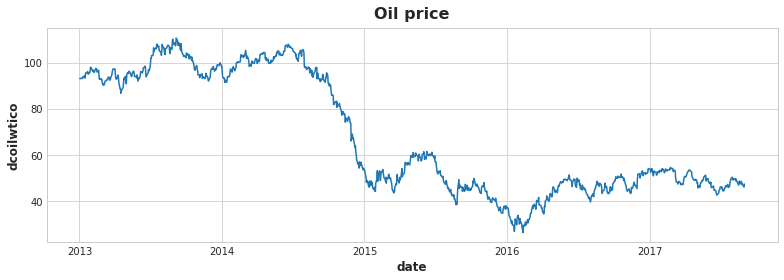

In [17]:
sns.lineplot(data=oil_data, x = 'date', y = 'dcoilwtico')
plt.title('Oil price')

**Checking Seasonal trends**

In [18]:
store_sales = pd.read_csv(
    work_dir + '/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [19]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

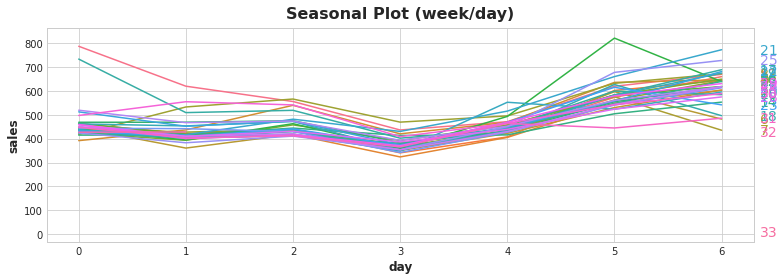

In [20]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

**Trying out a simple model with seasonality**

In [21]:
y = average_sales.copy()
fourier = CalendarFourier(freq="M", order = 4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

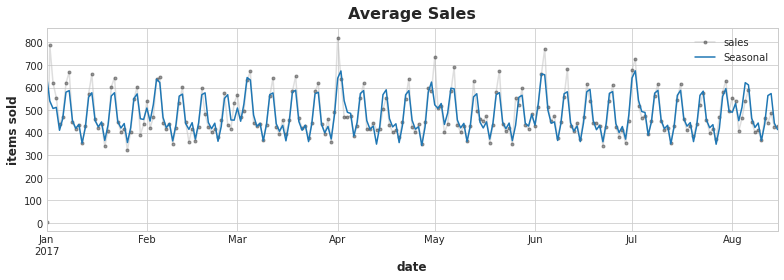

In [22]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)

# Plot
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

**Comparing deseasonalized plot with original to check if all seasonality is accounted for**

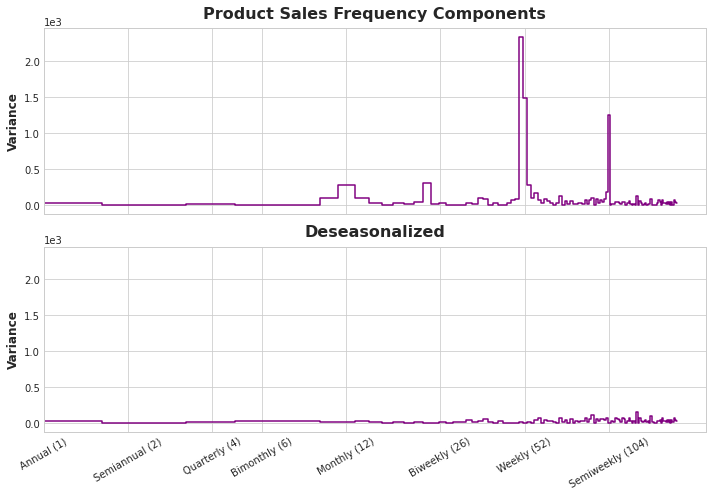

In [23]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

**Sales variation with holidays**

In [24]:
holidays_events = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


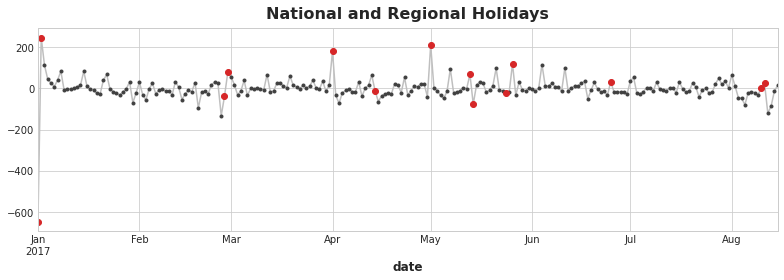

In [25]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

We can thus infer that there are seasonal trends for weekly, biweekly and monthly across all stores and the sales also depend on oil prices and holidays.

# **Functions for feature generation**

In [26]:
# Function for adding lag features
def lag_features(df, lags):
    for lag in lags:
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df

In [27]:
# Function for rolling average features
def roll_mean_features(df, windows):
    for window in windows:
        df['sales_roll_mean_' + str(window)] = df.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=7, win_type="triang").mean()) + random_noise(
            df)
    return df

In [28]:
# Random Noise
def random_noise(df):
    return np.random.normal(scale=2.0, size=(len(df),))


In [29]:
# Function for ewm features
def ewm_features(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                df.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return df

In [30]:
# Calendar features
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    return df

In [31]:
# Function to fill missing values
def fill_na(df):
    df['holiday_type'] = df['holiday_type'].fillna('Common')
    df['locale'] = df['locale'].fillna('Common')
    df['description'] = df['description'].fillna('Unknown')
    df['transferred'] = df['transferred'].fillna(False)
    df['dcoilwtico'] = df['dcoilwtico'].fillna(method='backfill')
    return df

In [32]:
# To merge all the created features 
def merge_data(df):
    df = df \
        .merge(stores_data, left_on="store_nbr", right_on="store_nbr", how="left") \
        .rename(columns={"type": "store_type"}) \
        .merge(transactions_data, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left") \
        .merge(holidays_data, left_on="date", right_on="date", how="left") \
        .drop_duplicates(subset="id") \
        .rename(columns={"type": "holiday_type"}) \
        .merge(oil_data, left_on="date", right_on="date", how="left") 
    return df


In [33]:
use_cols = ['date','store_nbr','family','sales','onpromotion','cluster','holiday_type', 
    'locale','description','transferred','dcoilwtico']

In [34]:
test_data = pd.read_csv(
    work_dir + '/test.csv'
)
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [35]:
test_id = test_data['id']
test_data['date'] = pd.to_datetime(test_data['date'])

# **Adding features to complete dataset**

In [36]:
data = pd.concat([train_data, test_data], axis=0)
data = merge_data(data)
data = data[use_cols]
data = fill_na(data)
data = create_date_features(data)
data = lag_features(data, lags = [*range(1, 16), 16,17,18,19,20,21,22,30,31,90,180,364])
data = roll_mean_features(data,[16,17,18,30])

In [37]:
data = ewm_features(data, [0.95, 0.9, 0.8, 0.5],[1, 7,30])

In [38]:
data['store_nbr'] = data['store_nbr'].astype('category')
data['family'] = data['family'].astype('category')
data['store_nbr'] = data['store_nbr'].astype('category')
data['cluster'] = data['cluster'].astype('category')
data['family'] = data['family'].astype('category')
data['holiday_type'] = data['holiday_type'].astype('category')
data['locale'] = data['locale'].astype('category')
data['description'] = data['description'].astype('category')

In [39]:
data.head()

,date,store_nbr,family,sales,onpromotion,cluster,holiday_type,locale,description,transferred,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_09_lag_1,sales_ewm_alpha_09_lag_7,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
0,2013-01-01,1,AUTOMOTIVE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,13,Holiday,National,Primer dia del ano,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Splitting test and train datasets according to dates**

In [40]:
data = data.query("date > '2013-12-31'")
X = data.query("date <= '2017-08-15'")
X_test = data.query("date > '2017-08-15'")
X.drop(['date'], inplace=True, axis=1)
X_test.drop(['date', 'year'], inplace=True, axis=1)

In [41]:
corr = X.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.973090
sales_ewm_alpha_08_lag_1      0.968657
sales_ewm_alpha_05_lag_7      0.966604
sales_ewm_alpha_09_lag_1      0.966508
sales_ewm_alpha_095_lag_1     0.965262
sales_ewm_alpha_08_lag_7      0.964625
sales_t-1                     0.963883
sales_ewm_alpha_09_lag_7      0.963186
sales_ewm_alpha_095_lag_7     0.962281
sales_t-7                     0.961233
sales_t-2                     0.958115
sales_t-3                     0.955286
sales_t-4                     0.953452
sales_t-6                     0.953263
sales_t-5                     0.952700
sales_t-14                    0.949117
sales_t-8                     0.949008
sales_t-9                     0.944701
sales_t-10                    0.942176
sales_t-13                    0.941201
sales_t-11                    0.940818
sales_t-12                    0.940049
sales_t-15                    0.937474
sales_t-21                    0.937108
sales_t-16               

**Sales v/s Other Features Correlation Heatmap**

<AxesSubplot:>

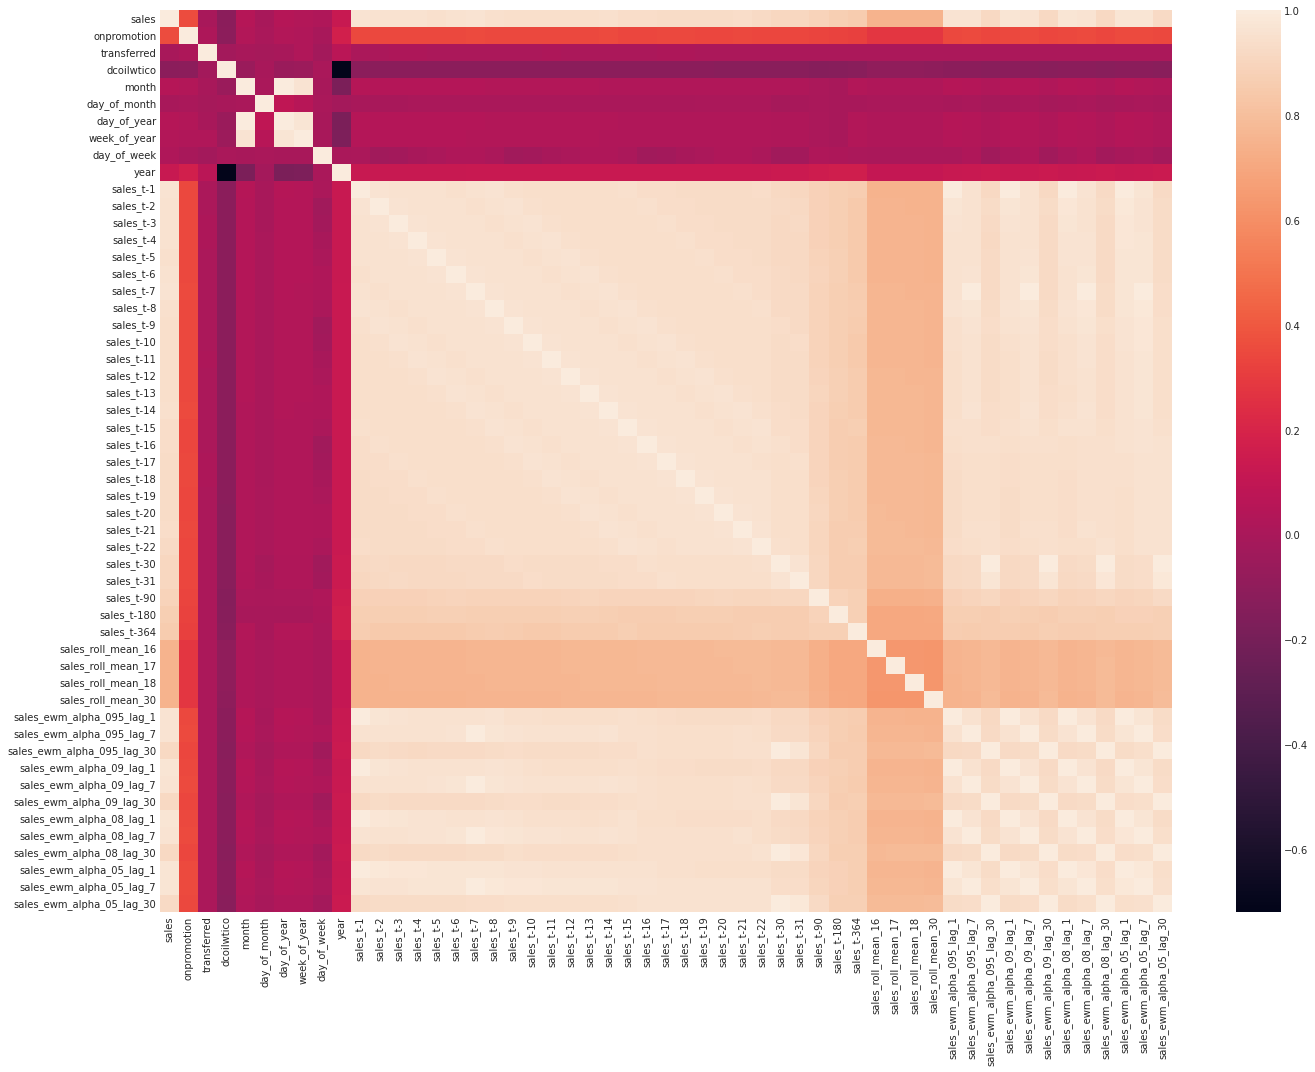

In [42]:
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, ax = ax)

In [43]:
Y = X['sales']
X = X.drop(['sales', 'year'], axis=1)
X_test = X_test.drop(['sales'], axis=1)

In [44]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [45]:
X_train.dtypes

store_nbr                     category
family                        category
onpromotion                      int64
cluster                       category
holiday_type                  category
locale                        category
description                   category
transferred                       bool
dcoilwtico                     float64
month                            int64
day_of_month                     int64
day_of_year                      int64
week_of_year                     int64
day_of_week                      int64
sales_t-1                      float64
sales_t-2                      float64
sales_t-3                      float64
sales_t-4                      float64
sales_t-5                      float64
sales_t-6                      float64
sales_t-7                      float64
sales_t-8                      float64
sales_t-9                      float64
sales_t-10                     float64
sales_t-11                     float64
sales_t-12               

# **Models**

In [46]:
def recursive_predict(model):
    global X_test
    output = np.array([])
    for day in range(16, 32):
        pred = model.predict(X_test.query(f"day_of_month == {day}"))
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, 32):
            X_test.loc[X_test[X_test["day_of_month"] == k].index, f"sales_t-{k-day}"] = pred
    return output

In [47]:
lgb_params = {
    'metric': 'mse',
    'boosting_type' : 'gbdt',
    'num_leaves': 8,
    'learning_rate': 0.2,
    'max_depth': 7,
    'verbose': 0,
    'num_boost_round': 5000,
    'early_stopping_rounds': 200,
    'nthread': -1,
    'force_col_wise': True,
}

train_dataset = lgb.Dataset(data=X_train, label=Y_train, feature_name='auto')
val_dataset = lgb.Dataset(data=X_val, label=Y_val, reference=train_dataset, feature_name='auto')

In [48]:
model = lgb.train(
    params=lgb_params, 
    train_set=train_dataset,
    valid_sets=[train_dataset, val_dataset],
    verbose_eval=100,
)

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.174109	valid_1's l2: 0.177073
[200]	training's l2: 0.161274	valid_1's l2: 0.164476
[300]	training's l2: 0.15419	valid_1's l2: 0.157816
[400]	training's l2: 0.149888	valid_1's l2: 0.153909
[500]	training's l2: 0.146809	valid_1's l2: 0.151076
[600]	training's l2: 0.144387	valid_1's l2: 0.149005
[700]	training's l2: 0.142324	valid_1's l2: 0.147225
[800]	training's l2: 0.140676	valid_1's l2: 0.145839
[900]	training's l2: 0.139377	valid_1's l2: 0.144876
[1000]	training's l2: 0.138038	valid_1's l2: 0.143799
[1100]	training's l2: 0.136925	valid_1's l2: 0.143053
[1200]	training's l2: 0.135926	valid_1's l2: 0.142315
[1300]	training's l2: 0.134791	valid_1's l2: 0.141534
[1400]	training's l2: 0.133973	valid_1's l2: 0.140992
[1500]	training's l2: 0.133268	valid_1's l2: 0.140561
[1600]	training's l2: 0.132358	valid_1's l2: 0.140028
[1700]	training's l2: 0.131678	valid_1's l2: 0.139644
[1800]	training's l2: 0.13097	

In [49]:
Y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
Y_val_pred[Y_val_pred < 0] = 0
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred)))

0.3663775200926235
0.1342324872292207


In [50]:
rec_pred_lgb = recursive_predict(model)

In [51]:
X_test = data.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

In [52]:
cat_indices = np.where(X_train.dtypes == 'category')[0]
train_dataset_cb = cb.Pool(X_train, Y_train, cat_features=cat_indices)
val_dataset_cb = cb.Pool(X_val, Y_val, cat_features=cat_indices)

model_cb = CatBoostRegressor(
    loss_function='RMSE',
    cat_features=cat_indices,
    max_depth=7,
    n_estimators=100
)
model_cb.fit(train_dataset_cb, eval_set=val_dataset_cb)

Learning rate set to 0.5
0:	learn: 1.4628983	test: 1.4626866	best: 1.4626866 (0)	total: 2.36s	remaining: 3m 53s
1:	learn: 0.8812822	test: 0.8823942	best: 0.8823942 (1)	total: 4.17s	remaining: 3m 24s
2:	learn: 0.6365314	test: 0.6379357	best: 0.6379357 (2)	total: 5.87s	remaining: 3m 9s
3:	learn: 0.5459554	test: 0.5476304	best: 0.5476304 (3)	total: 7.8s	remaining: 3m 7s
4:	learn: 0.5151817	test: 0.5170111	best: 0.5170111 (4)	total: 9.48s	remaining: 3m
5:	learn: 0.5005485	test: 0.5025834	best: 0.5025834 (5)	total: 11.2s	remaining: 2m 55s
6:	learn: 0.4889082	test: 0.4908199	best: 0.4908199 (6)	total: 13s	remaining: 2m 52s
7:	learn: 0.4816451	test: 0.4833236	best: 0.4833236 (7)	total: 14.9s	remaining: 2m 51s
8:	learn: 0.4752737	test: 0.4769575	best: 0.4769575 (8)	total: 16.5s	remaining: 2m 46s
9:	learn: 0.4705018	test: 0.4726067	best: 0.4726067 (9)	total: 18s	remaining: 2m 41s
10:	learn: 0.4646965	test: 0.4668391	best: 0.4668391 (10)	total: 19.5s	remaining: 2m 37s
11:	learn: 0.4605610	test: 

In [53]:
Y_val_pred_cb = model_cb.predict(X_val)
Y_val_pred_cb[Y_val_pred_cb < 0] = 0
print(np.sqrt(mean_squared_error(Y_val, Y_val_pred_cb)))
print(mean_squared_log_error(np.expm1(Y_val), np.expm1(Y_val_pred_cb)))

0.39972404436590087
0.1597793116442327


In [54]:
rec_pred_cb = recursive_predict(model_cb)

In [55]:
X_test = data.query("date > '2017-08-15'")
X_test.drop(['date', 'year', 'sales'], inplace=True, axis=1)

In [56]:
final_submission = pd.DataFrame({'id': test_id, 'sales': np.expm1(rec_pred_lgb)})
final_submission.to_csv('submission.csv', index=False)